In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Transaction

In [ ]:
data = pd.read_parquet("transaction_df.parquet")
print(data.shape)
data.head(5)

(875036, 5)


,product,price,amount,place,datetime
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.9,-0.079689,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00


In [ ]:
data['product'].unique()

array(['Целебные травы', 'Эльфийская пыльца', 'Эстус'], dtype=object)

In [ ]:
data['place'].unique()

array(['Анор Лондо', None, 'Врата Балдура', 'Кеджистан', 'Нокрон',
       'Фалькония'], dtype=object)

В данных представлено:



> **3 продукта**


*   `Целебные травы`

*   `Эльфийская пыльца`
*   `Эстус`




> **5 городов**



*   `Анор Лондо`

*   `Врата Балдура`

*   `Кеджистан`
*   `Нокрон`


*   `Фалькония`






Посмотрим, сколько всего пропущенных значений есть в данных:

In [ ]:
data.isnull().sum()

product       0
price         0
amount        0
place       432
datetime      0
dtype: int64

Удалим пропуски:

In [ ]:
data = data.dropna()
data.shape

(874604, 5)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874604 entries, 0 to 875035
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   product   874604 non-null  object        
 1   price     874604 non-null  float64       
 2   amount    874604 non-null  float64       
 3   place     874604 non-null  object        
 4   datetime  874604 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 40.0+ MB


В данных представлено 2 категориальных признака (продукт, город), 2 числовых признака (цена, количество), и признак (время) в формате datetime

In [ ]:
data.describe()

,price,amount
count,874604.000000,874604.000000
mean,-299.839940,0.739269
std,1407.352844,0.717876
min,-9998.990000,-0.500000
25%,6.850000,0.119514
50%,9.730000,0.733271
75%,13.800000,1.356703
max,31.200000,1.999999


Описательная статистика показала, что средняя и минимальная цены - отрицательны, а также минимальное значение количества - отрицательно. В данных есть выбросы.

Удалим очевидные выбросы, т.е. случаи, когда цена и количество товаров отрицательны

In [ ]:
data['price'] = data['price'].apply(lambda x: x if x>0 else None)

In [ ]:
data['amount'] = data['amount'].apply(lambda x: x if x>0 else None)

In [ ]:
data.head()

,product,price,amount,place,datetime
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00
1,Целебные травы,3.9,NaN,Анор Лондо,2216-01-02 16:21:00
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00


In [ ]:
data = data.dropna()
data.shape

(655659, 5)

Проверка:

In [ ]:
data.isnull().sum()

product     0
price       0
amount      0
place       0
datetime    0
dtype: int64

Посмотрим на описательную статистику после удаления отрицательных значений:

In [ ]:
data.describe()

,price,amount
count,655659.000000,655659.000000
mean,11.407969,0.987747
std,5.403327,0.576466
min,2.730000,0.000001
25%,7.490000,0.487804
50%,10.000000,0.982130
75%,14.140000,1.484279
max,31.200000,1.999999


Средняя цена по выборке составляет 11,408. При этом ровно половина выборки - товары со стоимостью меньше 10. Максимальная цена: 31,2.

Boxplot (ящик с усами) для поиска выбросов

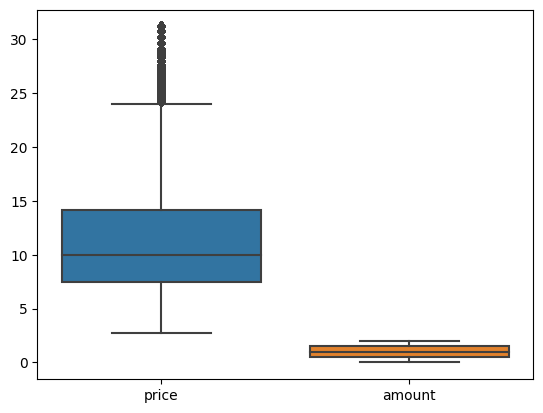

In [ ]:
columns = ['price','amount']
sns.boxplot(data[columns]);

Boxplot указывает на выбросы в цене, но удалять их не следует, т.к. присутствует инфляция, и без предыдущих актуальных цен нельзя будет предсказать будущие цены. Можно предположить, что данные цены не являются "аномалиями", а являются следствием инфляции и разницей между городами

In [ ]:
mx_price=data[data['price']== data['price'].max()]
mx_price.describe(include='object')

,product,place
count,559,559
unique,1,1
top,Эльфийская пыльца,Кеджистан
freq,559,559


Максимальная цена 31,2 достигается в 2218 году. Самым дорогим оказался продукт `"Эльфийская пыльца"`, и такие цены были установлены только в `Кеджистане`

In [ ]:
data.groupby('place')['price'].max().sort_values(ascending=False)

place
Кеджистан        31.20
Врата Балдура    27.47
Анор Лондо       19.27
Нокрон           18.11
Фалькония        15.35
Name: price, dtype: float64

Самые высокие цены можно наблюдать в городе Кеджистан, а самые низкие - в Фальконии

Распределения числовых данных:

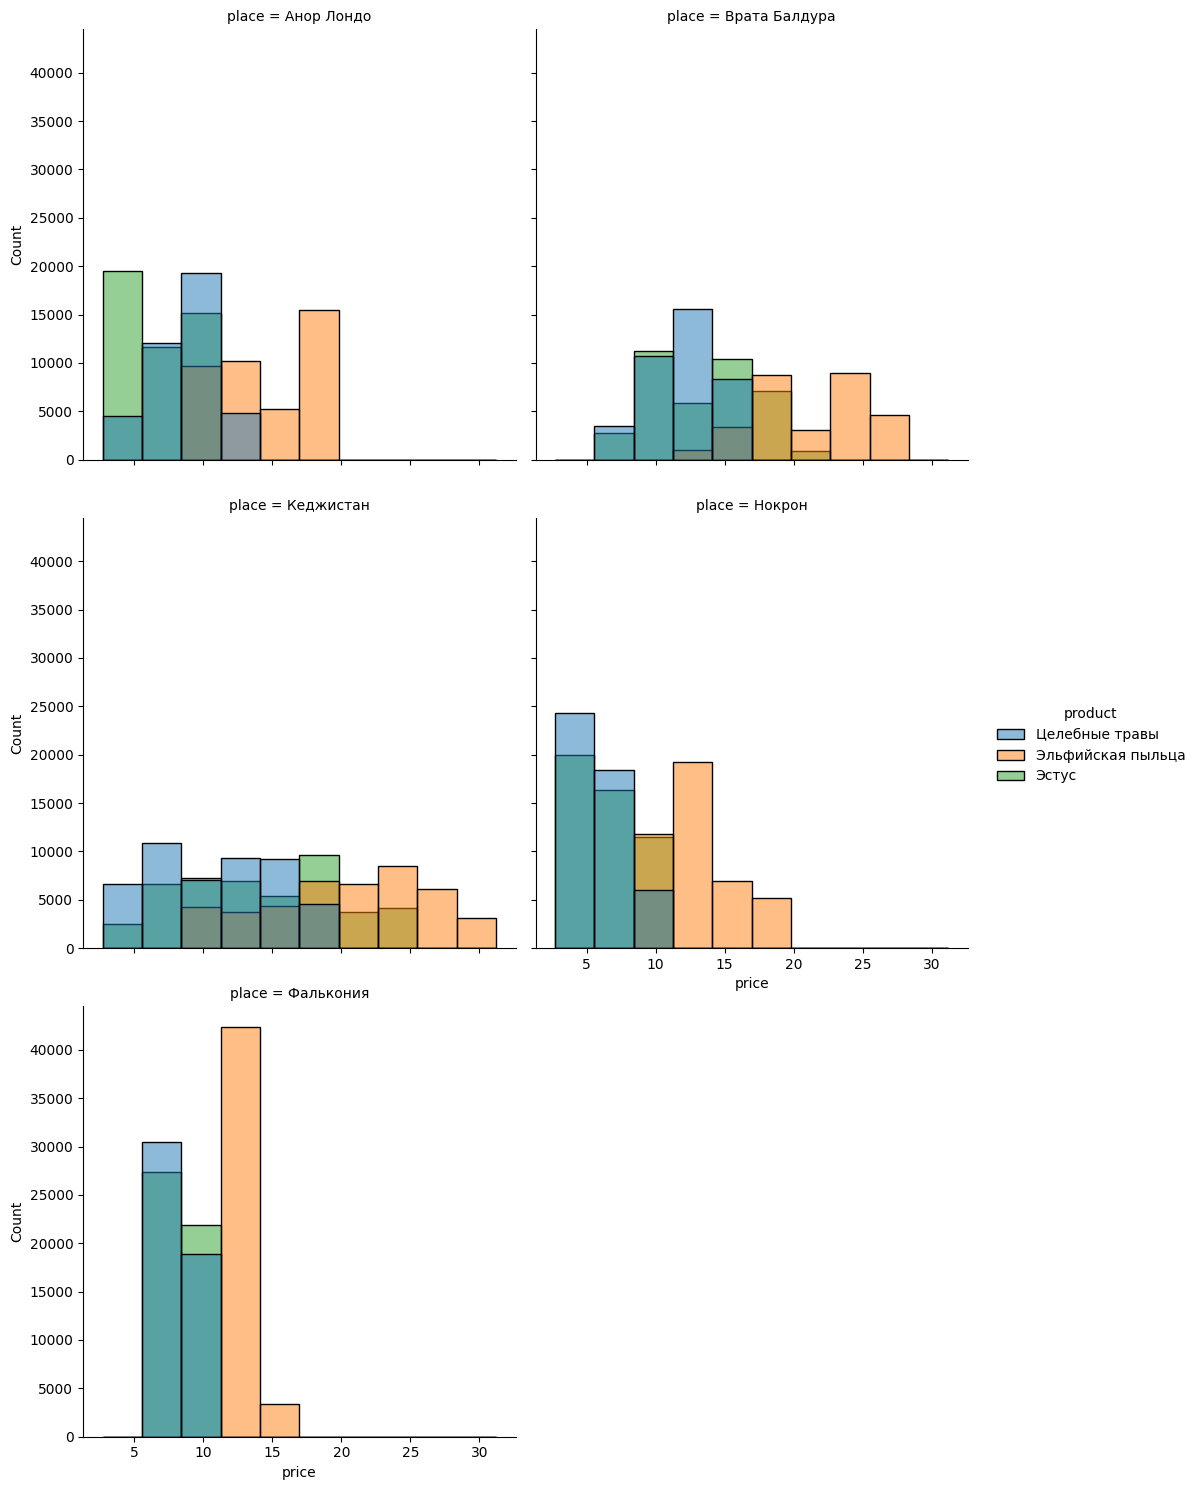

In [ ]:
sns.displot(data, x='price', col='place', col_wrap=2 ,bins=10, hue='product');

Исходя из визуализации распределений данных за всё время, можно заметить, что  самый дорогой товар - "Эльфийская пыльца"

In [ ]:
data['datetime']= pd.to_datetime(data['datetime'], format='%y-%m-%d')

data['date'] = pd.to_datetime(data['datetime'].dt.date)

In [ ]:
clean_data = data.copy()
del clean_data['datetime']
clean_data.head()

,product,price,amount,place,date
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02
6,Целебные травы,3.9,1.736619,Анор Лондо,2216-01-02


In [ ]:
data['year'] = data.date.apply(lambda x: x.year)
data['month'] = data.date.apply(lambda x: x.month)
data['day'] = data.date.apply(lambda x: x.day)
data['hour'] = data.datetime.apply(lambda x: x.hour)

data.head()

,product,price,amount,place,datetime,date,year,month,day,hour
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02 16:28:00,2216-01-02,2216,1,2,16
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02 03:03:00,2216-01-02,2216,1,2,3
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02 03:12:00,2216-01-02,2216,1,2,3
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02 05:33:00,2216-01-02,2216,1,2,5
6,Целебные травы,3.9,1.736619,Анор Лондо,2216-01-02 11:54:00,2216-01-02,2216,1,2,11


Анализ временных рядов:

In [ ]:
for year in data.year.unique():

  print(f'Количество месяцев в {year} году: ',\
        (data[data['year']==year]).month.nunique())

Количество месяцев в 2216 году:  12
Количество месяцев в 2217 году:  12
Количество месяцев в 2218 году:  9


array([[<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'hour'}>, <Axes: >]], dtype=object)

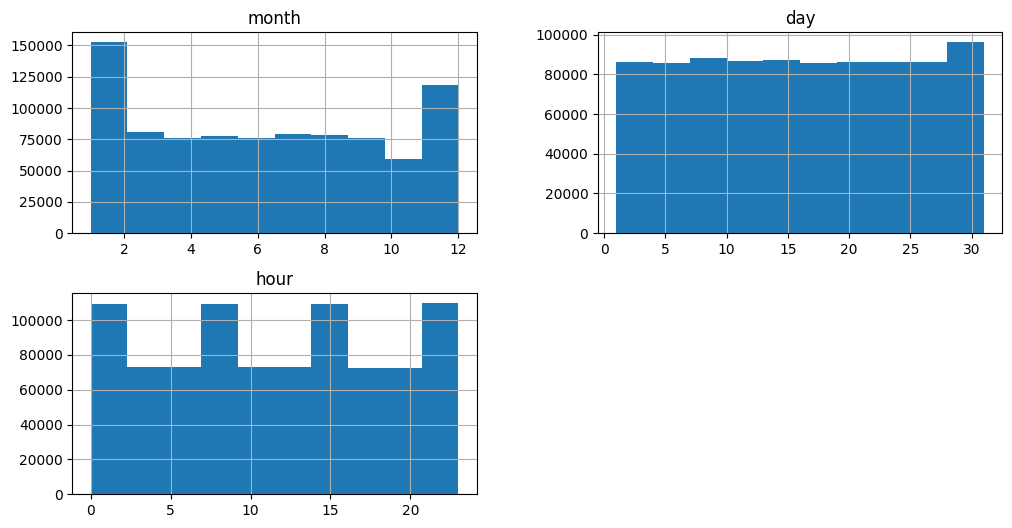

In [ ]:
col = ['month', 'day', 'hour']
data[col].hist(figsize=(12,6), bins= 10);

Агрегируем данные по году, городу, продукту и выведем среднее значение цены:

In [ ]:
stat=pd.DataFrame(
    data.groupby(['year','place','product'])\
    ['price'].mean()
)
stat

price
year place         product                     
2216 Анор Лондо    Целебные травы      6.466913
                   Эльфийская пыльца  11.051649
                   Эстус               4.752501
     Врата Балдура Целебные травы      9.459645
                   Эльфийская пыльца  17.253681
                   Эстус               9.681848
     Кеджистан     Целебные травы      6.163080
                   Эльфийская пыльца  14.012883
                   Эстус               8.038452
     Нокрон        Целебные травы      4.046721
                   Эльфийская пыльца  10.438777
                   Эстус               4.154520
     Фалькония     Целебные травы      6.736924
                   Эльфийская пыльца  12.444729
                   Эстус               6.951897
2217 Анор Лондо    Целебные травы      9.208420
                   Эльфийская пыльца  15.374375
                   Эстус               7.036481
     Врата Балдура Целебные травы     12.393016
                   Эльфийская пыльца  22.330917
                   Эстус              14.629636
     Кеджистан     Целебные травы     12.125409
                   Эльфийская пыльца  21.696138
                   Эстус              14.936380
     Нокрон        Целебные травы      6.010558
                   Эльфийская пыльца  12.898961
                   Эстус               6.589032
     Фалькония     Целебные травы      8.189636
                   Эльфийская пыльца  12.906950
                   Эстус               8.473147
2218 Анор Лондо    Целебные травы     11.083004
                   Эльфийская пыльца  18.121422
                   Эстус               9.684484
     Врата Балдура Целебные травы     14.721410
                   Эльфийская пыльца  25.730719
                   Эстус              17.799727
     Кеджистан     Целебные травы     16.404126
                   Эльфийская пыльца  27.253462
                   Эстус              21.224025
     Нокрон        Целебные травы      8.254458
                   Эльфийская пыльца  16.508731
                   Эстус               9.145966
     Фалькония     Целебные травы     10.038016
                   Эльфийская пыльца  13.280221
                   Эстус               9.637485

In [ ]:
stat1 = stat.copy()
stat1=stat1.reset_index(['place','product'])

stat1

,place,product,price
year,,,
2216,Анор Лондо,Целебные травы,6.466913
2216,Анор Лондо,Эльфийская пыльца,11.051649
2216,Анор Лондо,Эстус,4.752501
2216,Врата Балдура,Целебные травы,9.459645
2216,Врата Балдура,Эльфийская пыльца,17.253681
2216,Врата Балдура,Эстус,9.681848
2216,Кеджистан,Целебные травы,6.163080
2216,Кеджистан,Эльфийская пыльца,14.012883
2216,Кеджистан,Эстус,8.038452


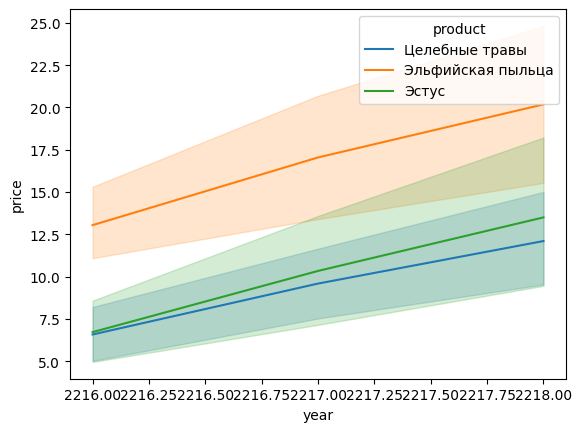

In [ ]:
sns.lineplot(data=stat1, x = 'year', y='price' , hue='product');

Несмотря на дисперсию цен (которая вызвана, например, местом продажи), они имеют общую тенденцию - инфляцию (устойчивый рост цен), и "стартовая" цена `Эльфийской пыльцы` начинается примерно на 6 золотых выше


---



Напишем функцию, которая будет возвращать средние цены из таблицы `stat1` на текущий момент для каждого продукта, в зависимости от места

In [ ]:
def place_price(place):

  print(stat1[stat1['place']==place]\
        .groupby('product')['price']\
        .max()\
        .sort_values(ascending=False))

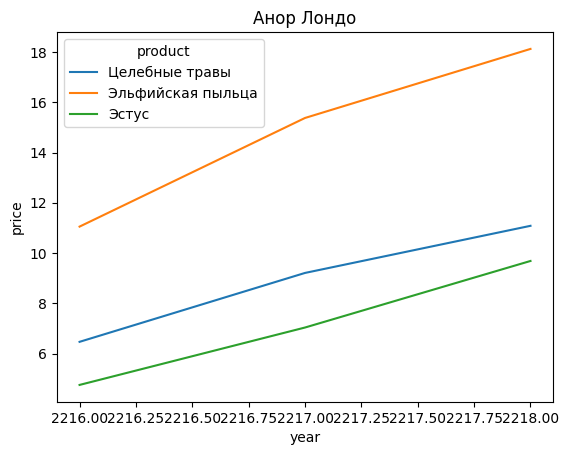

In [ ]:
sns.lineplot(data=stat1[stat1['place']=='Анор Лондо'],
             x = 'year',
             y='price' ,
             hue='product');

plt.title('Анор Лондо');

In [ ]:
place_price('Анор Лондо')

product
Эльфийская пыльца    18.121422
Целебные травы       11.083004
Эстус                 9.684484
Name: price, dtype: float64


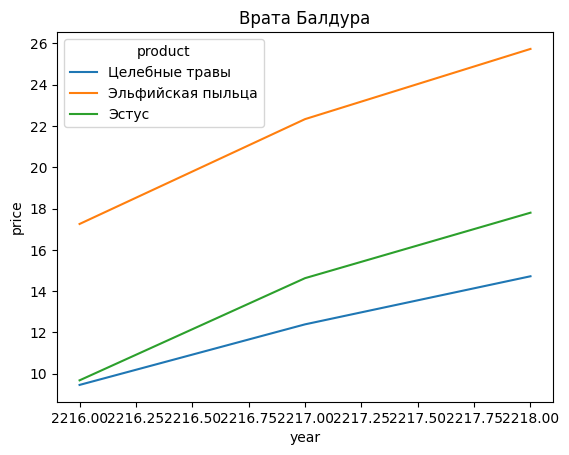

In [ ]:
sns.lineplot(data=stat1[stat1['place']=='Врата Балдура'],
             x = 'year',
             y='price' ,
             hue='product');

plt.title('Врата Балдура');

In [ ]:
place_price('Врата Балдура')

product
Эльфийская пыльца    25.730719
Эстус                17.799727
Целебные травы       14.721410
Name: price, dtype: float64


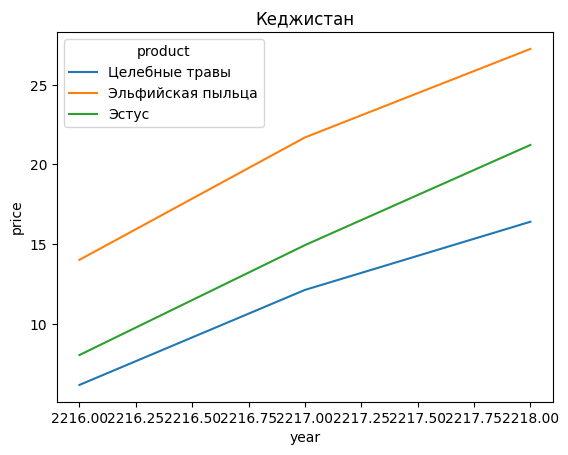

In [ ]:
sns.lineplot(data=stat1[stat1['place']=='Кеджистан'],
             x = 'year',
             y='price' ,
             hue='product');

plt.title('Кеджистан');

In [ ]:
place_price('Кеджистан')

product
Эльфийская пыльца    27.253462
Эстус                21.224025
Целебные травы       16.404126
Name: price, dtype: float64


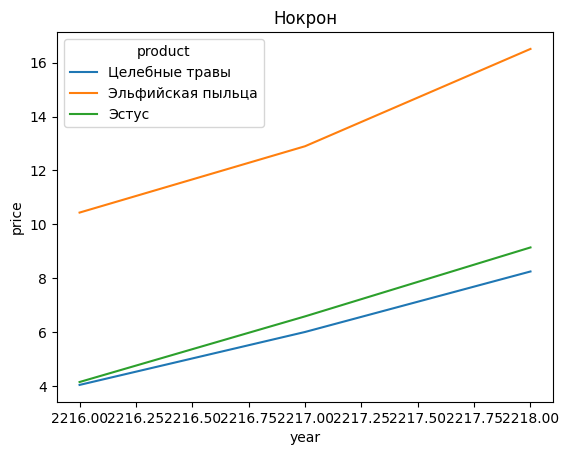

In [ ]:
sns.lineplot(data=stat1[stat1['place']=='Нокрон'],
             x = 'year',
             y='price' ,
             hue='product');

plt.title('Нокрон');

In [ ]:
place_price('Нокрон')

product
Эльфийская пыльца    16.508731
Эстус                 9.145966
Целебные травы        8.254458
Name: price, dtype: float64


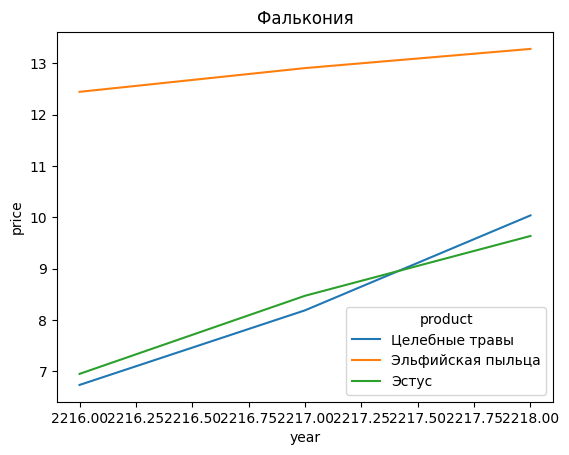

In [ ]:
sns.lineplot(data=stat1[stat1['place']=='Фалькония'],
             x = 'year',
             y='price' ,
             hue='product');

plt.title('Фалькония');

In [ ]:
place_price('Фалькония')

product
Эльфийская пыльца    13.280221
Целебные травы       10.038016
Эстус                 9.637485
Name: price, dtype: float64


Сгруппируем данные по признакам "год", "место", "продукт" и найдем общий объём продаж

In [ ]:
stat2 = pd.DataFrame(
    data.groupby(['year', 'place', 'product'])\
    ['amount']\
    .sum())
stat2=stat2.reset_index()

stat2

,year,place,product,amount
0,2216,Анор Лондо,Целебные травы,15245.506331
1,2216,Анор Лондо,Эльфийская пыльца,15379.545308
2,2216,Анор Лондо,Эстус,17049.330841
3,2216,Врата Балдура,Целебные травы,14893.918130
4,2216,Врата Балдура,Эльфийская пыльца,11681.767238
5,2216,Врата Балдура,Эстус,15353.524138
6,2216,Кеджистан,Целебные травы,18072.099167
7,2216,Кеджистан,Эльфийская пыльца,16014.837753
8,2216,Кеджистан,Эстус,16850.970252
9,2216,Нокрон,Целебные травы,18057.357891


In [ ]:
year2216 = stat2[stat2.year==2216]
year2217 = stat2[stat2.year==2217]
year2218 = stat2[stat2.year==2218]

Столбчатая диаграмма для категориальных признаков:

In [ ]:
def barplot(year,data):
  plt.figure(figsize = (12,6))

  sns.barplot(
      x='place',
      y='amount',
      data=data,
      palette='magma',
      hue='product');

  plt.title(f"Barplot of Place and Amount in {year}", fontsize = 20)
  plt.xlabel("Place", fontsize = 15)
  plt.ylabel("Amount", fontsize = 15)

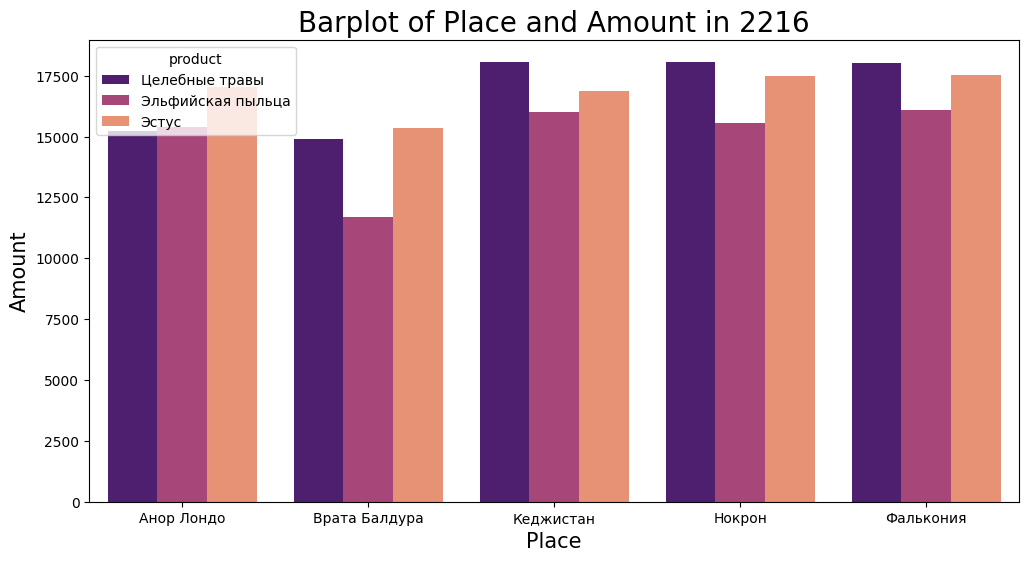

In [ ]:
barplot(2216, year2216)

In [ ]:
year2216[year2216.amount==year2216.amount.max()]

,year,place,product,amount
6,2216,Кеджистан,Целебные травы,18072.099167


In [ ]:
year2216.groupby('place')['amount']\
  .max()\
  .sort_values(ascending=False)

place
Кеджистан        18072.099167
Нокрон           18057.357891
Фалькония        18010.637087
Анор Лондо       17049.330841
Врата Балдура    15353.524138
Name: amount, dtype: float64

В 2216 году максимальный объем продаж был у товара `Целебные травы` в г. `Кеджистан`

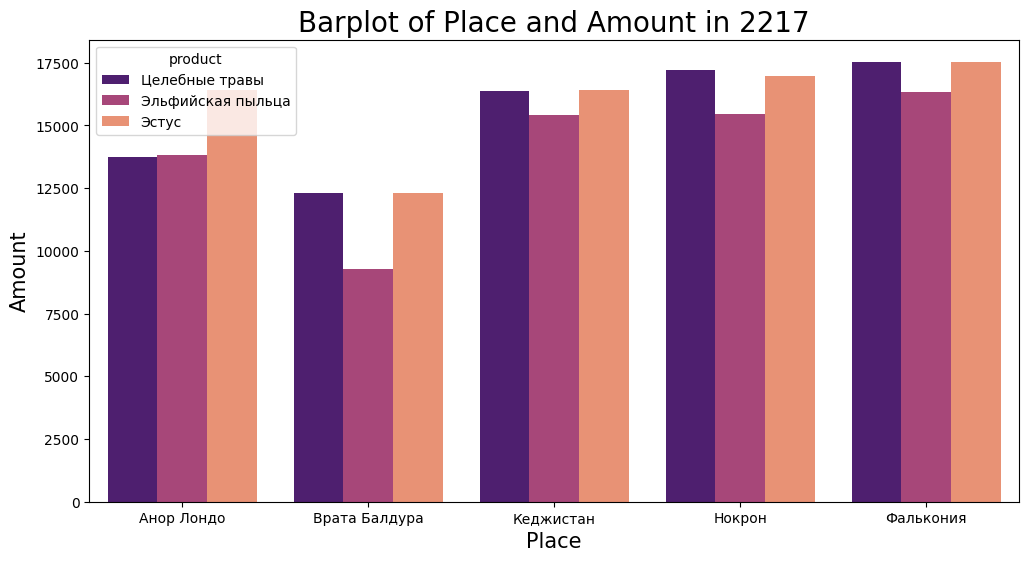

In [ ]:
barplot(2217, year2217)

In [ ]:
year2217[year2217.amount==year2217.amount.max()]

,year,place,product,amount
29,2217,Фалькония,Эстус,17540.296092


In [ ]:
year2217.groupby('place')['amount']\
  .max()\
  .sort_values(ascending=False)

place
Фалькония        17540.296092
Нокрон           17216.634834
Анор Лондо       16396.588891
Кеджистан        16393.145620
Врата Балдура    12323.336266
Name: amount, dtype: float64

В 2217 году максимальный объем продаж был у товара `Эстус` в г. `Фалькония`

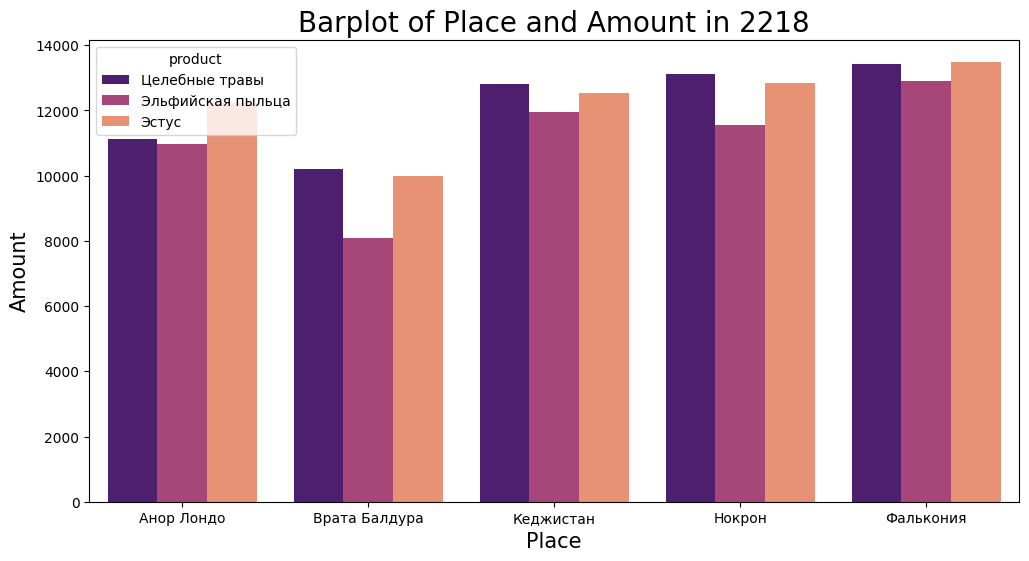

In [ ]:
barplot(2218, year2218)

In [ ]:
year2218[year2218.amount==year2218.amount.max()]

,year,place,product,amount
44,2218,Фалькония,Эстус,13495.779036


In [ ]:
year2218.groupby('place')['amount']\
  .max()\
  .sort_values(ascending=False)

place
Фалькония        13495.779036
Нокрон           13133.055013
Кеджистан        12810.585554
Анор Лондо       12241.426809
Врата Балдура    10199.075346
Name: amount, dtype: float64

В 2218 году максимальный объем продаж был у товара `Эстус` в г. `Фалькония`

# *Промежуточный итог:*

---



*  Самый дорогой продукт среди всех городов - `Эльфийская пыльца`

*  Во всех городах, кроме г. `Фалькония`, цены на `Эстус` выше, чем на `Целебные травы`

* Самые высокие цены установлены в г. `Кеджистан`

* За весь период, самый низкий совокупный объем продаж был в г. `Врата Балдура`

* В 2216 году, максимальный объем продаж был в г. `Кеджистан` у товара `Целебные травы`

* В 2217 и 2218, за последние 2 года, максимальный объем продаж был в г. `Фалькония` у товара `Эстус`

In [ ]:
clean_data.head()

,product,price,amount,place,date
0,Целебные травы,3.9,1.242125,Анор Лондо,2216-01-02
2,Целебные травы,3.9,0.882450,Анор Лондо,2216-01-02
3,Целебные травы,3.9,0.621377,Анор Лондо,2216-01-02
4,Целебные травы,3.9,1.367161,Анор Лондо,2216-01-02
6,Целебные травы,3.9,1.736619,Анор Лондо,2216-01-02


In [ ]:
data1 = pd.DataFrame(
    clean_data.groupby(['date','place','product'])\
     ['price','amount']\
    .agg({'price':np.mean, 'amount': np.sum})
    )


data1.head()

<ipython-input-18-3d9db5eaefcb>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clean_data.groupby(['date','place','product'])\


price     amount
date       place         product                            
2216-01-02 Анор Лондо    Целебные травы      3.90  37.802874
                         Эльфийская пыльца   9.21  52.490108
                         Эстус               3.60  46.831999
           Врата Балдура Целебные травы      7.29  32.914272
                         Эльфийская пыльца  13.42  26.228956

In [ ]:
data1=data1.reset_index(['place','product'])

data1 = data1.sort_index()

In [ ]:
data1['revenue'] = data1['price'] * data1['amount']
data1.head()

,place,product,price,amount,revenue
date,,,,,
2216-01-02,Анор Лондо,Целебные травы,3.90,37.802874,147.431210
2216-01-02,Анор Лондо,Эльфийская пыльца,9.21,52.490108,483.433896
2216-01-02,Анор Лондо,Эстус,3.60,46.831999,168.595198
2216-01-02,Врата Балдура,Целебные травы,7.29,32.914272,239.945042
2216-01-02,Врата Балдура,Эльфийская пыльца,13.42,26.228956,351.992592


Совокупная выручка по каждому городу:

In [ ]:
data1.groupby('place')['revenue'].sum().sort_values(ascending=False)

place
Кеджистан        2.051121e+06
Врата Балдура    1.567645e+06
Фалькония        1.382215e+06
Анор Лондо       1.245153e+06
Нокрон           1.139747e+06
Name: revenue, dtype: float64

Совокупная выручка по каждому товару:

In [ ]:
data1.groupby(['product'])['revenue'].sum().sort_values(ascending = False)

product
Эльфийская пыльца    3.218493e+06
Эстус                2.170617e+06
Целебные травы       1.996770e+06
Name: revenue, dtype: float64

Наибольшая выручка за всё время от продаж товара `Эльфийская пыльца`. Лидер по выручке - г. `Кеджистан`, аутсайдер -  г. `Нокрон`

In [ ]:
data1 = data1.reset_index()

Кодирование категориальных признаков:

In [ ]:
colmns1 = ['place', 'product']
dummy_data = pd.get_dummies(data1[colmns1])
dummy_data.head(4)

,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония,product_Целебные травы,product_Эльфийская пыльца,product_Эстус
0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0


Удаление по одному признаку каждой категориальной переменной для предотвращения мультиколлинеарности:

In [ ]:
data_dummy = pd.concat([data1, dummy_data.drop(['place_Фалькония', 'product_Эстус'],axis='columns')],axis='columns')
data_dummy = data_dummy.drop(['place', 'product'], axis=1)
data_dummy.head()

,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца
0,2216-01-02,3.90,37.802874,147.431210,1,0,0,0,1,0
1,2216-01-02,9.21,52.490108,483.433896,1,0,0,0,0,1
2,2216-01-02,3.60,46.831999,168.595198,1,0,0,0,0,0
3,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0
4,2216-01-02,13.42,26.228956,351.992592,0,1,0,0,0,1


In [ ]:
data_dummy.shape

(14998, 10)

In [ ]:
product = ['product_Целебные травы', 'product_Эльфийская пыльца']
place = ['place_Анор Лондо', 'place_Врата Балдура', 'place_Кеджистан', 'place_Нокрон']

Напишем функцию, которая для каждого города и каждого продукта будет создавать лаг на один день, чтобы посчитать разность между ценой и её лагом, и проверять, есть ли разность в ценах больше 1 золотой на следующий день после текущего

---



In [ ]:
def is_difference_more_1(place, product):
  table = data_dummy.copy()
  table = table[(data_dummy[place]==1) & data_dummy[product]==1]
  table['price_shift']=table['price'].shift(1)
  table['price_difference'] = table['price'] - table['price_shift']
  return len(table[table['price_difference']>1])

In [ ]:
for i in place:
  for j in product:
    print(is_difference_more_1(i,j))

0
0
0
0
0
0
0
0


В данных нет изменения цены больше, чем на 1 золотую

# Competitors

In [ ]:
comp = pd.read_parquet("df_competitors.parquet")
print(comp.shape)
comp.head(5)

(31799, 5)


,place,product,competitor,price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
5,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11


In [ ]:
comp['competitor'].unique()

array(['Арториас&Co', 'Длань господня', 'ЛилIT', 'Светлые Души'],
      dtype=object)



> **4 конкурента:**
* `Арториас&Co`
* `Длань господня`
* `ЛилIT`
* `Светлые Души`




In [ ]:
comp.isnull().sum()

place         0
product       0
competitor    0
price         0
date          0
dtype: int64

In [ ]:
comp.describe()

,price
count,31799.000000
mean,11.894810
std,5.574935
min,2.850000
25%,7.780000
50%,11.050000
75%,15.030000
max,31.940000


Ровно половина выборки - товары меньше 11 золотых (на 1 з. больше, чем медиана наших цен). А максимальная цена выше на 0,74 з.

Переименуем столбец `price` на `comp_price`, чтобы можно было далее соединить данную таблицу, с таблицей "Транзакции" и сравнить цены с нашими

In [ ]:
comp=comp.rename(columns={"price": "comp_price"})
comp.head(5)

,place,product,competitor,comp_price,date
0,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-04
1,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-05
2,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-06
3,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-09
5,Анор Лондо,Целебные травы,Арториас&Co,3.78,2216-01-11


In [ ]:
clean_comp = comp.copy()

Агрегируем данные по конкуренту и продукту и выведем максимальные цены для каждого из них за весь период

In [ ]:
pd.DataFrame(
  comp.groupby(['competitor','product'])['comp_price']\
  .max()\
  .sort_values(ascending=False))

,,comp_price
competitor,product,
Арториас&Co,Эльфийская пыльца,31.94
Светлые Души,Эльфийская пыльца,31.92
Длань господня,Эльфийская пыльца,31.13
ЛилIT,Эльфийская пыльца,30.92
Светлые Души,Эстус,27.66
Длань господня,Эстус,26.67
ЛилIT,Эстус,21.97
Арториас&Co,Эстус,20.13
Светлые Души,Целебные травы,17.29


In [ ]:
comp.groupby('competitor')['comp_price'].mean().sort_values(ascending=False)

competitor
Светлые Души      12.581663
Длань господня    12.058258
ЛилIT             11.649778
Арториас&Co       11.282089
Name: comp_price, dtype: float64

Максимальную цену установил конкурент `"Арториас&Co"`, по товару `Эльфийская пыльца`, но в среднем, его товары дешевле, чем товары других. `Эльфийская пыльца` также является самым дорогим среди всех конкурентов.

In [ ]:
colmns = ['place', 'product', 'competitor']
dummy_comp = pd.get_dummies(comp[colmns])
dummy_comp.head(4)

,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония,product_Целебные травы,product_Эльфийская пыльца,product_Эстус,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT,competitor_Светлые Души
0,1,0,0,0,0,1,0,0,1,0,0,0
1,1,0,0,0,0,1,0,0,1,0,0,0
2,1,0,0,0,0,1,0,0,1,0,0,0
3,1,0,0,0,0,1,0,0,1,0,0,0


Чтобы избежать мультиколлинеарности, удаляем по 1 столбцу каждого категориального признака

In [ ]:
comp_dummy = pd.concat([comp,dummy_comp.drop(['place_Фалькония', 'product_Эстус','competitor_Светлые Души'],axis='columns')],axis='columns')
comp_dummy = comp_dummy.drop(['place', 'product', 'competitor'], axis=1)
comp_dummy.head()

,comp_price,date,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT
0,3.78,2216-01-04,1,0,0,0,1,0,1,0,0
1,3.78,2216-01-05,1,0,0,0,1,0,1,0,0
2,3.78,2216-01-06,1,0,0,0,1,0,1,0,0
3,3.78,2216-01-09,1,0,0,0,1,0,1,0,0
5,3.78,2216-01-11,1,0,0,0,1,0,1,0,0


In [ ]:
comp_dummy.shape

(31799, 11)

Чтобы объединить 2 таблицы по одинаковым столбцам, соберем все совпадающие столбцы в один список:

---



In [ ]:
col = list(np.where(1*(data_dummy.columns).isin(comp_dummy.columns)==1, data_dummy.columns, 0))
col = [i for i in col if i != 0]
col

['date',
 'place_Анор Лондо',
 'place_Врата Балдура',
 'place_Кеджистан',
 'place_Нокрон',
 'product_Целебные травы',
 'product_Эльфийская пыльца']

In [ ]:
dummy_merge = data_dummy.merge(comp_dummy, how = 'left', on = col)
dummy_merge

,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,comp_price,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT
0,2216-01-02,3.90,37.802874,147.431210,1,0,0,0,1,0,4.21,0.0,1.0,0.0
1,2216-01-02,9.21,52.490108,483.433896,1,0,0,0,0,1,9.79,1.0,0.0,0.0
2,2216-01-02,3.60,46.831999,168.595198,1,0,0,0,0,0,NaN,NaN,NaN,NaN
3,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.68,1.0,0.0,0.0
4,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.81,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32492,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,16.32,1.0,0.0,0.0
32493,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,20.86,0.0,1.0,0.0
32494,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,18.55,0.0,0.0,1.0
32495,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,20.94,0.0,0.0,0.0


In [ ]:
dummy_merge.shape

(32497, 14)

In [ ]:
dummy_merge.isnull().sum()

date                           0
price                          0
amount                         0
revenue                        0
place_Анор Лондо               0
place_Врата Балдура            0
place_Кеджистан                0
place_Нокрон                   0
product_Целебные травы         0
product_Эльфийская пыльца      0
comp_price                   702
competitor_Арториас&Co       702
competitor_Длань господня    702
competitor_ЛилIT             702
dtype: int64

In [ ]:
dummy_merge = dummy_merge.dropna()

Создадим столбец, который будет показывать прирост показателя цены над ценой конкурента

In [ ]:
dummy_merge['price_diff'] = (dummy_merge['price'] - dummy_merge['comp_price'])/dummy_merge['comp_price']

<ipython-input-39-220dac895c7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_merge['price_diff'] = (dummy_merge['price'] - dummy_merge['comp_price'])/dummy_merge['comp_price']


In [ ]:
dummy_merge.head(10)

,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,comp_price,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT,price_diff
0,2216-01-02,3.90,37.802874,147.431210,1,0,0,0,1,0,4.21,0.0,1.0,0.0,-0.073634
1,2216-01-02,9.21,52.490108,483.433896,1,0,0,0,0,1,9.79,1.0,0.0,0.0,-0.059244
3,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.68,1.0,0.0,0.0,-0.050781
4,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.81,0.0,1.0,0.0,-0.066581
5,2216-01-02,13.42,26.228956,351.992592,0,1,0,0,0,1,11.96,0.0,1.0,0.0,0.122074
6,2216-01-02,13.42,26.228956,351.992592,0,1,0,0,0,1,12.50,0.0,0.0,1.0,0.073600
7,2216-01-02,7.80,31.571146,246.254942,0,1,0,0,0,0,8.45,0.0,0.0,0.0,-0.076923
8,2216-01-02,3.69,52.348454,193.165796,0,0,1,0,1,0,4.18,1.0,0.0,0.0,-0.117225
9,2216-01-02,3.69,52.348454,193.165796,0,0,1,0,1,0,4.33,0.0,1.0,0.0,-0.147806
10,2216-01-02,9.05,53.296328,482.331768,0,0,1,0,0,1,8.85,0.0,0.0,0.0,0.022599


Столбец `price_diff_percent` будет принимать значение 0, если наша цена на 20% больше цены конкурента, и 1 иначе

In [ ]:
dummy_merge['price_diff_percent'] = np.where(dummy_merge['price_diff']>0.2, 0, 1)
dummy_merge[dummy_merge['price_diff_percent']==0]

<ipython-input-40-a52ca73c8ae2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_merge['price_diff_percent'] = np.where(dummy_merge['price_diff']>0.2, 0, 1)


,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,comp_price,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT,price_diff,price_diff_percent
486,2216-01-16,4.70,35.274507,165.790181,0,0,1,0,0,0,3.90,0.0,0.0,0.0,0.205128,0
520,2216-01-17,4.70,52.469119,246.604860,0,0,1,0,0,0,3.90,0.0,0.0,0.0,0.205128,0
551,2216-01-18,4.70,47.162524,221.663862,0,0,1,0,0,0,3.90,0.0,0.0,0.0,0.205128,0
584,2216-01-19,4.70,47.160441,221.654074,0,0,1,0,0,0,3.89,0.0,0.0,0.0,0.208226,0
618,2216-01-20,4.70,35.028889,164.635777,0,0,1,0,0,0,3.89,0.0,0.0,0.0,0.208226,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32466,2218-09-27,13.63,37.672160,513.471539,1,0,0,0,1,0,8.07,0.0,0.0,0.0,0.688971,0
32469,2218-09-27,10.68,44.420709,474.413176,1,0,0,0,0,0,6.97,1.0,0.0,0.0,0.532281,0
32480,2218-09-27,19.09,43.524190,830.876788,0,0,1,0,1,0,15.79,0.0,0.0,1.0,0.208993,0
32483,2218-09-27,24.42,45.163825,1102.900616,0,0,1,0,0,0,20.13,1.0,0.0,0.0,0.213115,0


В 3162 строках цены превышают цены конкурентов более, чем на 20%

In [ ]:
data1_comp = data1.merge(comp, how = 'left', on = ['date','place','product'])
data1_comp

,date,place,product,price,amount,revenue,competitor,comp_price
0,2216-01-02,Анор Лондо,Целебные травы,3.90,37.802874,147.431210,Длань господня,4.21
1,2216-01-02,Анор Лондо,Эльфийская пыльца,9.21,52.490108,483.433896,Арториас&Co,9.79
2,2216-01-02,Анор Лондо,Эстус,3.60,46.831999,168.595198,NaN,NaN
3,2216-01-02,Врата Балдура,Целебные травы,7.29,32.914272,239.945042,Арториас&Co,7.68
4,2216-01-02,Врата Балдура,Целебные травы,7.29,32.914272,239.945042,Длань господня,7.81
...,...,...,...,...,...,...,...,...
32492,2218-09-27,Фалькония,Эльфийская пыльца,15.28,45.144098,689.801815,Арториас&Co,16.32
32493,2218-09-27,Фалькония,Эльфийская пыльца,15.28,45.144098,689.801815,Длань господня,20.86
32494,2218-09-27,Фалькония,Эльфийская пыльца,15.28,45.144098,689.801815,ЛилIT,18.55
32495,2218-09-27,Фалькония,Эльфийская пыльца,15.28,45.144098,689.801815,Светлые Души,20.94


In [ ]:
data1_comp.date.nunique()

1000

In [ ]:
data1_comp.isnull().sum()

date            0
place           0
product         0
price           0
amount          0
revenue         0
competitor    702
comp_price    702
dtype: int64

In [ ]:
data1_comp = data1_comp.dropna()

# Weather

In [ ]:
weath = pd.read_parquet("weather_df.parquet")
print(weath.shape)
weath.head(5)

(5000, 5)


,place,hot,rain,snow,date
0,Фалькония,0,0,0,2216-01-02
1,Анор Лондо,1,0,0,2216-01-02
2,Врата Балдура,0,0,1,2216-01-02
3,Нокрон,0,0,0,2216-01-02
4,Кеджистан,0,0,1,2216-01-02


In [ ]:
weath.isnull().sum()

place    0
hot      0
rain     0
snow     0
date     0
dtype: int64

In [ ]:
weath[['hot','rain','snow']].value_counts()

hot  rain  snow
0    0     0       2425
1    0     0        876
0    1     0        863
     0     1        836
dtype: int64

In [ ]:
print('В',100 * 2425/weath.shape[0],'% случаев, не было ни жары, ни дождя, ни снега')

В 48.5 % случаев, не было ни жары, ни дождя, ни снега


Кодирование категориального признака:

In [ ]:
col=['place']
dummy_weath = pd.get_dummies(weath[col])
dummy_weath.head(4)

,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония
0,0,0,0,0,1
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0


In [ ]:
weath_dummy = pd.concat([weath,dummy_weath.drop(['place_Фалькония'],axis='columns')],axis='columns')
weath_dummy = weath_dummy.drop(['place'], axis=1)
weath_dummy.head()

,hot,rain,snow,date,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон
0,0,0,0,2216-01-02,0,0,0,0
1,1,0,0,2216-01-02,1,0,0,0
2,0,0,1,2216-01-02,0,1,0,0
3,0,0,0,2216-01-02,0,0,0,1
4,0,0,1,2216-01-02,0,0,1,0


In [ ]:
dummy_merge.head(3)

,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,comp_price,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT,price_diff,price_diff_percent
0,2216-01-02,3.90,37.802874,147.431210,1,0,0,0,1,0,4.21,0.0,1.0,0.0,-0.073634,1
1,2216-01-02,9.21,52.490108,483.433896,1,0,0,0,0,1,9.79,1.0,0.0,0.0,-0.059244,1
3,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.68,1.0,0.0,0.0,-0.050781,1


Признаки, по которым будут объединены таблицы:

In [ ]:
clms = list(np.where(1*(dummy_merge.columns).isin(weath_dummy.columns)==1, dummy_merge.columns, 0))
clms = [i for i in clms if i != 0]
clms

['date',
 'place_Анор Лондо',
 'place_Врата Балдура',
 'place_Кеджистан',
 'place_Нокрон']

In [ ]:
dummy_merge1 = dummy_merge.merge(weath_dummy, how = 'left', on = clms)
dummy_merge1

,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,comp_price,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT,price_diff,price_diff_percent,hot,rain,snow
0,2216-01-02,3.90,37.802874,147.431210,1,0,0,0,1,0,4.21,0.0,1.0,0.0,-0.073634,1,1,0,0
1,2216-01-02,9.21,52.490108,483.433896,1,0,0,0,0,1,9.79,1.0,0.0,0.0,-0.059244,1,1,0,0
2,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.68,1.0,0.0,0.0,-0.050781,1,0,0,1
3,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.81,0.0,1.0,0.0,-0.066581,1,0,0,1
4,2216-01-02,13.42,26.228956,351.992592,0,1,0,0,0,1,11.96,0.0,1.0,0.0,0.122074,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31790,2218-09-27,10.97,45.452870,498.617984,0,0,0,0,1,0,15.03,0.0,1.0,0.0,-0.270126,1,0,0,0
31791,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,16.32,1.0,0.0,0.0,-0.063725,1,0,0,0
31792,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,20.86,0.0,1.0,0.0,-0.267498,1,0,0,0
31793,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,18.55,0.0,0.0,1.0,-0.176280,1,0,0,0


# Costs

In [ ]:
costs = pd.read_parquet("df_cost.parquet")
print(costs.shape)
costs.head(5)

(1117, 4)


,place,product,cost,date
0,Анор Лондо,Целебные травы,2.07,2216-01-02
1,Анор Лондо,Целебные травы,3.07,2216-01-26
2,Анор Лондо,Целебные травы,3.30,2216-02-12
3,Анор Лондо,Целебные травы,4.04,2216-03-06
4,Анор Лондо,Целебные травы,3.88,2216-03-27


In [ ]:
costs.date.nunique()

685

In [ ]:
costs.describe()

,cost
count,1117.000000
mean,6.859955
std,3.856876
min,1.180000
25%,3.910000
50%,5.930000
75%,8.860000
max,24.520000


In [ ]:
costs[costs['cost']==costs['cost'].max()]

,place,product,cost,date
550,Кеджистан,Эльфийская пыльца,24.52,2218-09-06


В среднем, издержки на производство 1 унции составляют 1117, ровно половина выборки меньше 5,93, максимальные затраты составляют 24,52 и были достигнуты в 2218-09-06, в городе `Кеджистан` на производстве продукта `Эльфийская пыльца`

In [ ]:
colm=['place', 'product']
dummy_costs = pd.get_dummies(costs[colm])
dummy_costs.head(4)

,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,place_Фалькония,product_Целебные травы,product_Эльфийская пыльца,product_Эстус
0,1,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0
2,1,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,0


In [ ]:
costs_dummy = pd.concat([costs, dummy_costs.drop(['place_Фалькония', 'product_Эстус'],axis='columns')],axis='columns')
costs_dummy = costs_dummy.drop(['place','product'], axis=1)
costs_dummy.head()

,cost,date,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца
0,2.07,2216-01-02,1,0,0,0,1,0
1,3.07,2216-01-26,1,0,0,0,1,0
2,3.30,2216-02-12,1,0,0,0,1,0
3,4.04,2216-03-06,1,0,0,0,1,0
4,3.88,2216-03-27,1,0,0,0,1,0


In [ ]:
clm = list(np.where(1*(dummy_merge.columns).isin(costs_dummy.columns)==1, dummy_merge.columns, 0))
clm = [i for i in clm if i != 0]
clm

['date',
 'place_Анор Лондо',
 'place_Врата Балдура',
 'place_Кеджистан',
 'place_Нокрон',
 'product_Целебные травы',
 'product_Эльфийская пыльца']

In [ ]:
dummy_merge2 = dummy_merge1.merge(costs_dummy, how = 'left', on = clm)
dummy_merge2

,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,comp_price,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT,price_diff,price_diff_percent,hot,rain,snow,cost
0,2216-01-02,3.90,37.802874,147.431210,1,0,0,0,1,0,4.21,0.0,1.0,0.0,-0.073634,1,1,0,0,2.07
1,2216-01-02,9.21,52.490108,483.433896,1,0,0,0,0,1,9.79,1.0,0.0,0.0,-0.059244,1,1,0,0,3.46
2,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.68,1.0,0.0,0.0,-0.050781,1,0,0,1,3.63
3,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,7.81,0.0,1.0,0.0,-0.066581,1,0,0,1,3.63
4,2216-01-02,13.42,26.228956,351.992592,0,1,0,0,0,1,11.96,0.0,1.0,0.0,0.122074,1,0,0,1,5.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31790,2218-09-27,10.97,45.452870,498.617984,0,0,0,0,1,0,15.03,0.0,1.0,0.0,-0.270126,1,0,0,0,NaN
31791,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,16.32,1.0,0.0,0.0,-0.063725,1,0,0,0,NaN
31792,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,20.86,0.0,1.0,0.0,-0.267498,1,0,0,0,NaN
31793,2218-09-27,15.28,45.144098,689.801815,0,0,0,0,0,1,18.55,0.0,0.0,1.0,-0.176280,1,0,0,0,NaN


Рассчитаем общие затраты (издержки на 1 унцию * кол-во продаж)

In [ ]:
dummy_merge2['total_costs'] = dummy_merge2['amount'] * dummy_merge2['cost']
dummy_merge2.head(4)

,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,...,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT,price_diff,price_diff_percent,hot,rain,snow,cost,total_costs
0,2216-01-02,3.90,37.802874,147.431210,1,0,0,0,1,0,...,0.0,1.0,0.0,-0.073634,1,1,0,0,2.07,78.251950
1,2216-01-02,9.21,52.490108,483.433896,1,0,0,0,0,1,...,1.0,0.0,0.0,-0.059244,1,1,0,0,3.46,181.615774
2,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,...,1.0,0.0,0.0,-0.050781,1,0,0,1,3.63,119.478807
3,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,...,0.0,1.0,0.0,-0.066581,1,0,0,1,3.63,119.478807


Рассчитаем прибыль = выручка - совокупные издержки

In [ ]:
dummy_merge2['profit'] = dummy_merge2['revenue']-dummy_merge2['total_costs']
dummy_merge2.head(3)

,date,price,amount,revenue,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,...,competitor_Длань господня,competitor_ЛилIT,price_diff,price_diff_percent,hot,rain,snow,cost,total_costs,profit
0,2216-01-02,3.90,37.802874,147.431210,1,0,0,0,1,0,...,1.0,0.0,-0.073634,1,1,0,0,2.07,78.251950,69.179260
1,2216-01-02,9.21,52.490108,483.433896,1,0,0,0,0,1,...,0.0,0.0,-0.059244,1,1,0,0,3.46,181.615774,301.818122
2,2216-01-02,7.29,32.914272,239.945042,0,1,0,0,1,0,...,0.0,0.0,-0.050781,1,0,0,1,3.63,119.478807,120.466235


Корреляционная матрица для поиска зависимости в данных:

---



<ipython-input-74-94f685320fdc>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=data.drop(labels=labels, axis=1).corr(), annot=True)


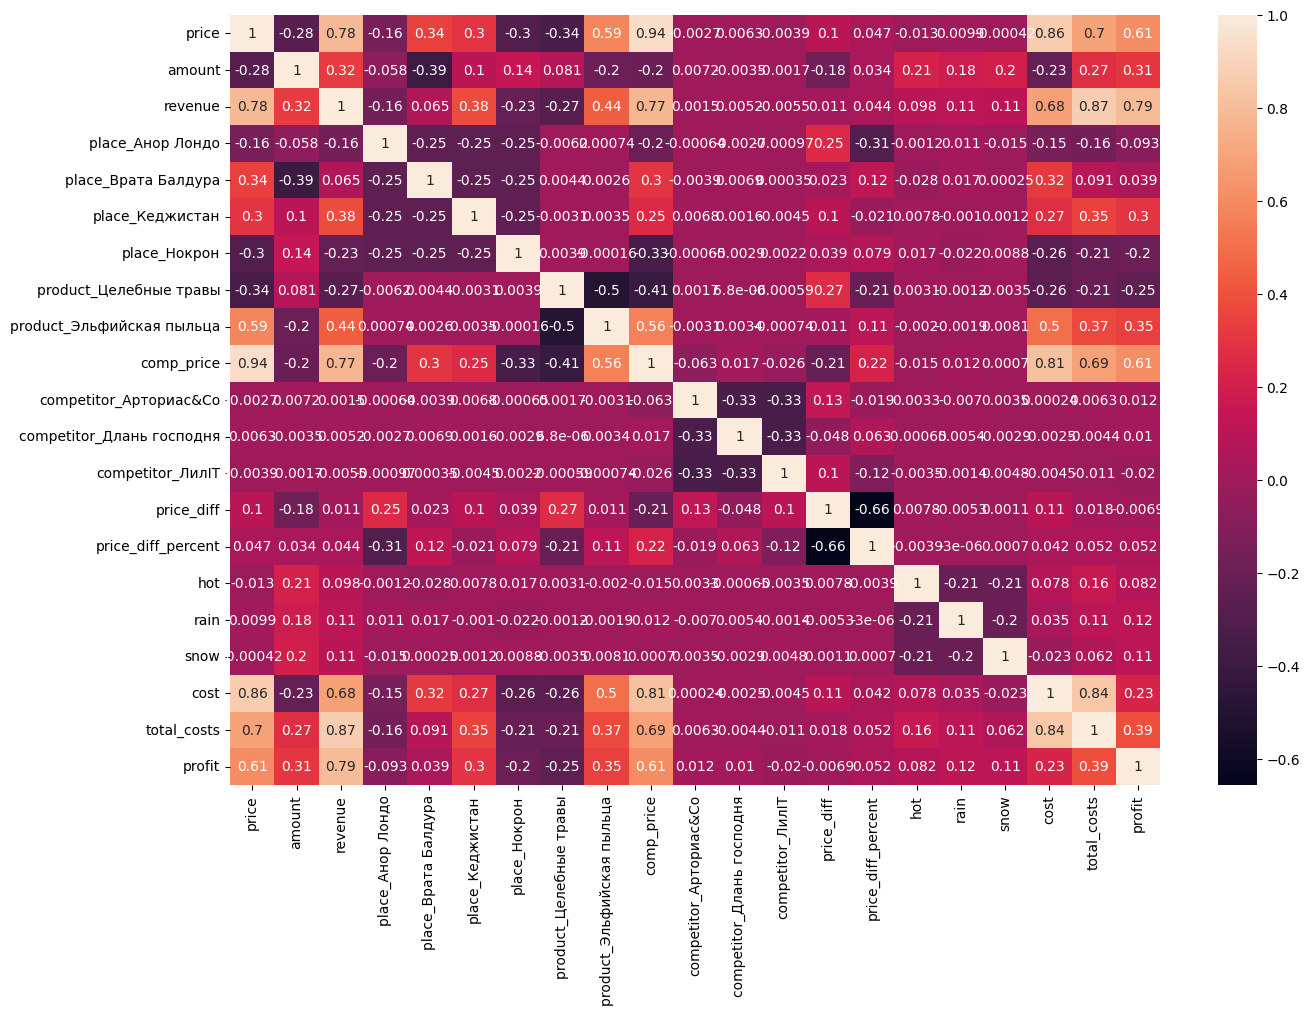

In [ ]:
def corrplot(data,labels=[]):
    f,ax = plt.subplots(figsize=(15,10))
    sns.heatmap(data=data.drop(labels=labels, axis=1).corr(), annot=True)
    plt.show()
corrplot(data=dummy_merge2);

Итоги корреляционного анализа:

---
* *Цена* и *количество* имеют отрицательную корреляцию: соответствие с основным экономическим законом, законом спроса - чем выше цена, тем ниже продажи
* Наши *цены* очень коррелируют с *ценами конкурентов* (0,94): для предсказания наших цен, нужно предсказать цены конкурентов
* *Цены* также коррелируют и с *издержками*: чем выше издержки, тем выше устанавливаем цену
* *Цены конкурентов* влияют на наши *цены*, и, как следствие, на *выручку* и *прибыль*


# Models

Предсказание цен конкурентов:

---



Разобьем выборку на обучающую и тестовую, для этого выберем квантиль 95%

In [ ]:
qntl = comp_dummy['date'].quantile(0.95)
qntl

Timestamp('2218-08-08 00:00:00')

In [ ]:
comp_dummy=comp_dummy.set_index('date')
comp_dummy.head(5)

,comp_price,place_Анор Лондо,place_Врата Балдура,place_Кеджистан,place_Нокрон,product_Целебные травы,product_Эльфийская пыльца,competitor_Арториас&Co,competitor_Длань господня,competitor_ЛилIT
date,,,,,,,,,,
2216-01-04,3.78,1,0,0,0,1,0,1,0,0
2216-01-05,3.78,1,0,0,0,1,0,1,0,0
2216-01-06,3.78,1,0,0,0,1,0,1,0,0
2216-01-09,3.78,1,0,0,0,1,0,1,0,0
2216-01-11,3.78,1,0,0,0,1,0,1,0,0


In [ ]:
X_train = comp_dummy[comp_dummy.index <= qntl].drop(['comp_price'], axis=1)         #Срез по таблице без целевой переменной с датой выборки до 95%-го квантиля
X_test = comp_dummy[comp_dummy.index > qntl].drop(['comp_price'], axis=1)

y_train = (comp_dummy[comp_dummy.index <= qntl])[['comp_price']]                 # Целевая переменная с датой выборки до 95%-го квантиля
y_test = (comp_dummy[comp_dummy.index > qntl])[['comp_price']]

# **Linear Regression**

In [ ]:
lr = LinearRegression()          # Создание объекта
lr.fit(X_train, y_train)           # Обучение модели
lr_pred = lr.predict(X_test)          # Прогноз

Напишем функцию, которая будет принимать на вход название модели, полученные прогнозы от уже обученной модели, тестовую выборку, для рассчетов метрик **MSE** (среднеквадратичной ошибки) и **MAPE** (среднее абсолютное процентное отклонение) ,будет возвращать таблицу с соответствующими значениями:

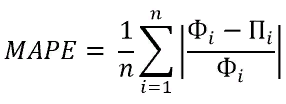

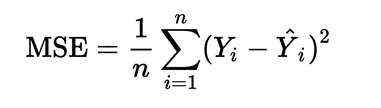

In [ ]:
def report(model, y_pred, y_test):

  mse = mean_squared_error(y_pred ,y_test)
  mape = mean_absolute_percentage_error(y_pred ,y_test)
  report = pd.DataFrame({'mse':mse,
                         'mape':mape},
                         index=[model])
  return report

In [ ]:
df=report(LinearRegression(), lr_pred, y_test)
df

,mse,mape
LinearRegression(),36.876783,0.460278


# **XGBRegressor**

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_pred=xgb.predict(X_test)

In [ ]:
df2 = report(XGBRegressor, xgb_pred, y_test)
df2

,mse,mape
<class 'xgboost.sklearn.XGBRegressor'>,33.722093,0.450461


In [ ]:
df = pd.concat([df,df2])
df

,mse,mape
LinearRegression(),36.876783,0.460278
<class 'xgboost.sklearn.XGBRegressor'>,33.722093,0.450461


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


# **CatBoostRegressor**

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
ctb = CatBoostRegressor()

In [ ]:
ctb.fit(X_train, y_train)

Learning rate set to 0.070163
0:	learn: 5.1764096	total: 7.42ms	remaining: 7.41s
1:	learn: 4.9690880	total: 11.2ms	remaining: 5.58s
2:	learn: 4.7825570	total: 17.4ms	remaining: 5.78s
3:	learn: 4.6151720	total: 25.3ms	remaining: 6.31s
4:	learn: 4.4653627	total: 30.7ms	remaining: 6.12s
5:	learn: 4.3343603	total: 33.9ms	remaining: 5.62s
6:	learn: 4.2191673	total: 37ms	remaining: 5.25s
7:	learn: 4.1117420	total: 40.5ms	remaining: 5.02s
8:	learn: 4.0165256	total: 43.9ms	remaining: 4.83s
9:	learn: 3.9319927	total: 47.3ms	remaining: 4.68s
10:	learn: 3.8573226	total: 50.7ms	remaining: 4.56s
11:	learn: 3.7902990	total: 54.1ms	remaining: 4.45s
12:	learn: 3.7320116	total: 57.4ms	remaining: 4.36s
13:	learn: 3.6790531	total: 60.8ms	remaining: 4.28s
14:	learn: 3.6318463	total: 64.7ms	remaining: 4.25s
15:	learn: 3.5913936	total: 68ms	remaining: 4.18s
16:	learn: 3.5543264	total: 71.3ms	remaining: 4.12s
17:	learn: 3.5218485	total: 74.7ms	remaining: 4.08s
18:	learn: 3.4922044	total: 77.9ms	remaining: 4.

In [ ]:
ctb_pred=ctb.predict(X_test)

In [ ]:
df3 = report(CatBoostRegressor, ctb_pred, y_test)
df3

,mse,mape
<class 'catboost.core.CatBoostRegressor'>,33.722408,0.450458


In [ ]:
df = pd.concat([df, df3])

In [ ]:
df

,mse,mape
LinearRegression(),36.876783,0.460278
<class 'xgboost.sklearn.XGBRegressor'>,33.722093,0.450461
<class 'catboost.core.CatBoostRegressor'>,33.722408,0.450458


# **RandomForestRegressor**

In [ ]:
param_grid = {'n_estimators': [50, 100, 200, 300, 400],            # количество деревьев
              'max_depth': [3, 10, 20, 30, 80]}                    # максимальная глубина дерева

rf = RandomForestRegressor()                      # создание объекта

rf_grid_search = GridSearchCV(rf, param_grid, cv=2)

rf_grid_search.fit(X_train, y_train)                   # обучение модели


print('Лучшие параметры: ', rf_grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Лучшие параметры:  {'max_depth': 80, 'n_estimators': 50}


Лучшие параметры:  {'max_depth': 80, 'n_estimators': 50}

In [ ]:
rf = RandomForestRegressor(max_depth= 80, n_estimators = 50)
rf.fit(X_train, y_train)

<ipython-input-206-289f5568cf23>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=80, n_estimators=50)

In [ ]:
rf_pred = rf.predict(X_test)           # прогноз

In [ ]:
df4=report('RandomForestRegressor', rf_pred, y_test)

In [ ]:
df = pd.concat([df,df4])
df

,mse,mape
LinearRegression(),36.876783,0.460278
<class 'xgboost.sklearn.XGBRegressor'>,33.722093,0.450461
<class 'catboost.core.CatBoostRegressor'>,33.722408,0.450458
RandomForestRegressor,33.693573,0.450289


Согласно метрикам, лучшая модель среди представленных -  **RandomForestRegressor**

Визуализация признаков по важности для модели:

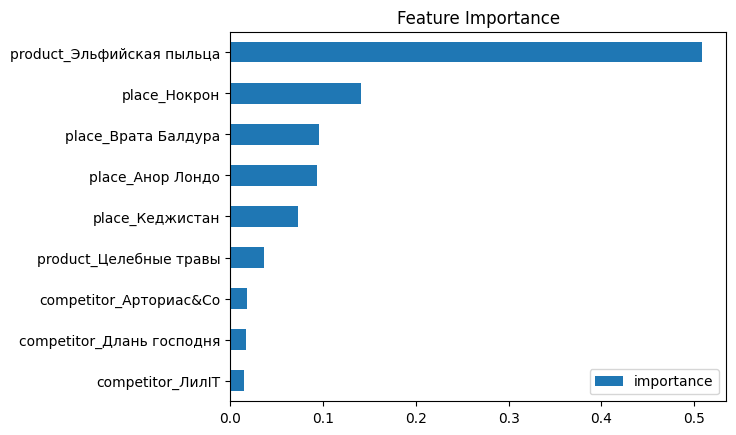

In [ ]:
fi = pd.DataFrame(data=rf.feature_importances_,
             index=rf.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Наиболее важный признак для предсказания цены- товар `Эльфийская пыльца`

In [ ]:
X_test.columns

Index(['place_Анор Лондо', 'place_Врата Балдура', 'place_Кеджистан',
       'place_Нокрон', 'product_Целебные травы', 'product_Эльфийская пыльца',
       'competitor_Арториас&Co', 'competitor_Длань господня',
       'competitor_ЛилIT'],
      dtype='object')

Функция, которая будет создавать таблицу, совпадающей по размерности с тестовой выборкой, изначально заполненная 0, затем определяем индекс столбца относительно аргументов и отмечаем 1. На выходе - прогноз для 90 дней по указанным условиям   

In [ ]:
def predict_price(place,product,competitor):
    place_index = np.where(X_test.columns==place)[0][0]
    product_index = np.where(X_test.columns==product)[0][0]
    competitor_index = np.where(X_test.columns==competitor)[0][0]

    x = pd.DataFrame(0, index=np.arange(90), columns=X_test.columns)            # все столбцы 0
    x['date'] = pd.date_range(start=X_test.index[-1], periods=90)
    x = x.set_index('date')                                                            # 90 дней
    x.iloc[:, place_index] = 1                                                         # в указанном городе 1
    x.iloc[:, product_index] = 1                                                       # в указанном продукте 1
    x.iloc[:, competitor_index] = 1                                                    # в указанном конкуренте 1
    return rf.predict(x)

In [ ]:
predict_price('place_Кеджистан', 'product_Целебные травы','competitor_Арториас&Co')

array([9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289063,
       9.80289063, 9.80289063, 9.80289063, 9.80289063, 9.80289

In [ ]:
np.where(x.columns=='place_Нокрон')[0][0]

4

In [ ]:
pd.date_range(start=X_test.index[-1], periods=90)

DatetimeIndex(['2218-09-24', '2218-09-25', '2218-09-26', '2218-09-27',
               '2218-09-28', '2218-09-29', '2218-09-30', '2218-10-01',
               '2218-10-02', '2218-10-03', '2218-10-04', '2218-10-05',
               '2218-10-06', '2218-10-07', '2218-10-08', '2218-10-09',
               '2218-10-10', '2218-10-11', '2218-10-12', '2218-10-13',
               '2218-10-14', '2218-10-15', '2218-10-16', '2218-10-17',
               '2218-10-18', '2218-10-19', '2218-10-20', '2218-10-21',
               '2218-10-22', '2218-10-23', '2218-10-24', '2218-10-25',
               '2218-10-26', '2218-10-27', '2218-10-28', '2218-10-29',
               '2218-10-30', '2218-10-31', '2218-11-01', '2218-11-02',
               '2218-11-03', '2218-11-04', '2218-11-05', '2218-11-06',
               '2218-11-07', '2218-11-08', '2218-11-09', '2218-11-10',
               '2218-11-11', '2218-11-12', '2218-11-13', '2218-11-14',
               '2218-11-15', '2218-11-16', '2218-11-17', '2218-11-18',
      

# Итог работы

---



Хочу выразить огромную благодарность ПАО "Газпромнефть" за содействие в развитии и поддержании талантливых студентов, предоставления возможности участия в мероприятиях, стажировках, а также создании профильных магистратур в сотрудничестве с более, чем 30 ВУЗами России.

Отдельные слова благодарности хочу выразить организаторам конкурса "GPN CUP" за интересные и непростые задания, которые требуют нешаблонности и проявления креатива в решении

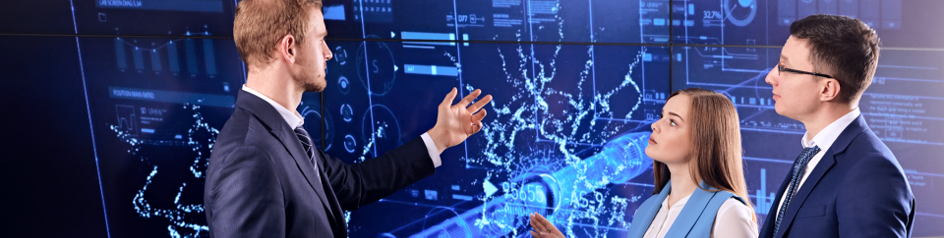